In [1]:
import trueskill
import statistics
import math
import matplotlib.pyplot as plt
import numpy as np
import operator
import copy
import pickle
with open('ratings.pkl', 'rb') as f:
    ratings = pickle.load(f)
with open('A_qns.pkl', 'rb') as f:
    A_qns = pickle.load(f)
with open('lower_qns_bank_A.pkl', 'rb') as f:
    lower_qns_bank_A = pickle.load(f)
with open('lower_qns_bank_AB.pkl', 'rb') as f:
    lower_qns_bank_AB = pickle.load(f)
with open('lower_qns_bank_ABC.pkl', 'rb') as f:
    lower_qns_bank_ABC = pickle.load(f)
with open('all_qns.pkl', 'rb') as f:
    all_qns = pickle.load(f)
with open('all_qns_bank_A.pkl', 'rb') as f:
    all_qns_bank_A = pickle.load(f)
with open('all_qns_bank_AB.pkl', 'rb') as f:
    all_qns_bank_AB = pickle.load(f)
with open('all_qns_bank_ABC.pkl', 'rb') as f:
    all_qns_bank_ABC = pickle.load(f)

In [2]:
mu=25.000
sigma=8.333
beta=4.167
tau=0
draw_probability=0
trueskill.setup(mu=mu, sigma=sigma, beta=beta, tau=tau, draw_probability=draw_probability, backend=None)

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.000, draw_probability=0.0%)

In [3]:
def win_probability(player1, player2):
    
    delta_mu = player1.mu - player2.mu
    sum_sigma = player1.sigma ** 2 + player2.sigma ** 2
    denom = math.sqrt(2 * (beta * beta) + sum_sigma)
    ts = trueskill.global_env()
    
    return ts.cdf(delta_mu / denom)

In [4]:
# Four different methods of selecting best question

In [4]:
# Method 1: Using trueskill's draw probability function. Pick the qn with the highest draw probability

def select_best_qn(student_rating, questions):
    
    draw_prob = {}
    for qn in questions:
        draw_prob[qn] = []
    
    for qn in questions:
        draw_prob[qn] = trueskill.quality_1vs1(student_rating, ratings[qn])
        
    best_qn = max(draw_prob.items(), key = operator.itemgetter(1))[0]
    
    return best_qn

In [492]:
# Method 2: If student gets qn correct we give a harder qn next, if student gets qn wrong we give an easier qn next

def select_best_qn(student_rating, questions, prev_winner):
    
    rating_difference = {}
    
    for qn in questions:
        rating_difference[qn] = student_rating.mu - ratings[qn].mu
        
    if prev_winner == 'student':
        qn_bank = {k:v  for k, v in rating_difference.items() if v < 0}
        best_qn = max(qn_bank.items(), key = operator.itemgetter(1))[0]
    else:
        qn_bank = {k:v  for k, v in rating_difference.items() if v > 0}
        best_qn = min(qn_bank.items(), key = operator.itemgetter(1))[0]
    
    return best_qn

In [519]:
# Method 3: Always give student a harder qn since the ratings are constantly adjusted

def select_best_qn(student_rating, questions):
    
    rating_difference = {}
    
    for qn in questions:
        rating_difference[qn] = student_rating.mu - ratings[qn].mu
        
    qn_bank = {k:v  for k, v in rating_difference.items() if v < 0}
    best_qn = max(qn_bank.items(), key = operator.itemgetter(1))[0]

    return best_qn

In [5]:
# Method 4: Pick question with the smallest absolute difference in ratings

def select_best_qn(student_rating, questions):
    
    rating_difference = {}
    
    for qn in questions:
        rating_difference[qn] = abs(student_rating.mu - ratings[qn].mu)
        
    best_qn = min(rating_difference.items(), key = operator.itemgetter(1))[0]

    return best_qn

In [6]:
def get_match_outcome(student, question):
    
    match_outcome = ()
    
    if np.random.uniform() <= win_probability(ratings[student], ratings[question]):
        match_outcome = ('student', 'question')
    else:
        match_outcome = ('question', 'student')
    
    return match_outcome

In [7]:
# Code to use for Methods 1, 3 and 4

def get_ratings_convergence(student, questions, num_qns_ans):
      
    student_rating = trueskill.Rating()
    student_rating_mu = [student_rating.mu]
    rating_difference = []
    question_bank = copy.deepcopy(questions)
                
    for i in range(num_qns_ans):
        
        best_qn = select_best_qn(student_rating, question_bank)
        question_bank.remove(best_qn)
        
        rating_difference.append(abs(student_rating.mu - ratings[best_qn].mu))
        
        match_outcome = get_match_outcome(student, best_qn)
        
        if match_outcome[0] == 'student':
            student_rating, discard = trueskill.rate_1vs1(student_rating, ratings[best_qn])
        else:
            discard, student_rating = trueskill.rate_1vs1(ratings[best_qn], student_rating)
    
        student_rating_mu.append(student_rating.mu)
    
    return student_rating_mu, rating_difference

In [493]:
# Code to use for Method 2

def get_ratings_convergence(student, questions, num_qns_ans):
      
    student_rating = trueskill.Rating()
    student_rating_mu = [student_rating.mu]
    rating_difference = []
    question_bank = copy.deepcopy(questions)
    prev_winner = 'student'
                
    for i in range(num_qns_ans):
        
        best_qn = select_best_qn(student_rating, question_bank, prev_winner)
        question_bank.remove(best_qn)
        
        rating_difference.append(abs(student_rating.mu - ratings[best_qn].mu))
        
        match_outcome = get_match_outcome(student, best_qn)
        
        if match_outcome[0] == 'student':
            student_rating, discard = trueskill.rate_1vs1(student_rating, ratings[best_qn])
            prev_winner = 'student'
        else:
            discard, student_rating = trueskill.rate_1vs1(ratings[best_qn], student_rating)
            prev_winner = 'question'
    
        student_rating_mu.append(student_rating.mu)
    
    return student_rating_mu, rating_difference

In [8]:
def plot_convergence(student, questions, num_qns_ans):
    
    student_rating, rating_difference = get_ratings_convergence(student, questions, num_qns_ans)
    num_qns = list(range(len(student_rating)))
    num_qns_2 = list(range(len(student_rating)-1))
    real_rating = ratings[student].mu
    
    plt.plot(num_qns, student_rating, label = 'student rating')
    # plt.plot(num_qns_2, rating_difference, color = 'green', label = 'difference in student and question rating')
    plt.axhline(y = real_rating, color = 'r', linestyle = '-')
    plt.xlabel('No. of questions answered by student')
    plt.ylabel('Rating of student')
    plt.title('True mu = ' + str(ratings[student].mu))
    # plt.legend(loc = 'center')
    plt.show
    plt.savefig('graph.png')

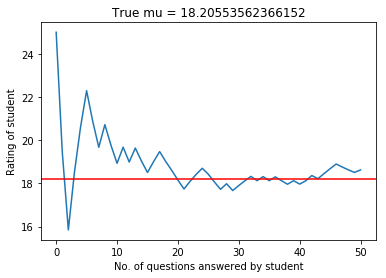

In [17]:
# Method 4
plot_convergence('I242', A_qns, 50)

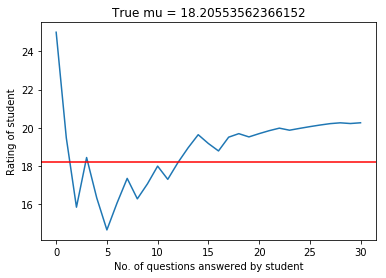

In [15]:
# Method 4
plot_convergence('I242', lower_qns_bank_A, 30)

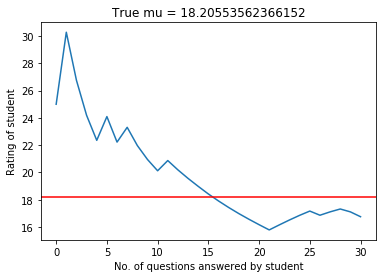

In [11]:
# Method 4
plot_convergence('I242', lower_qns_bank_AB, 30)

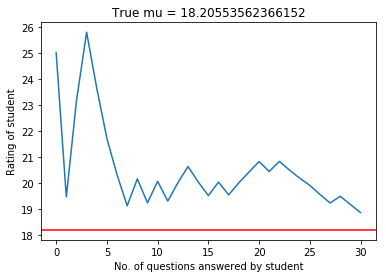

In [12]:
# Method 4
plot_convergence('I242', lower_qns_bank_ABC, 30)

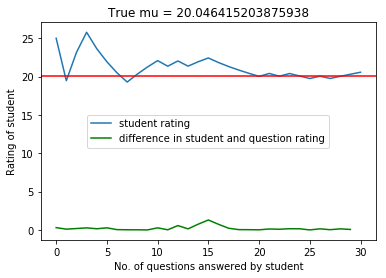

In [158]:
# Method 4
plot_convergence('I078', lower_qns, 30)

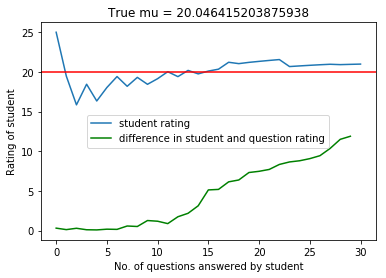

In [159]:
# Method 4
plot_convergence('I078', lower_qns_bank_A, 30)

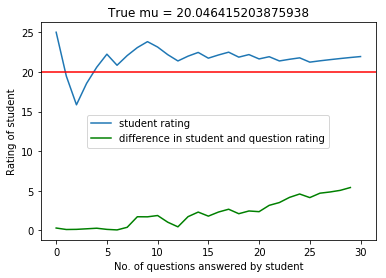

In [160]:
# Method 4
plot_convergence('I078', lower_qns_bank_AB, 30)

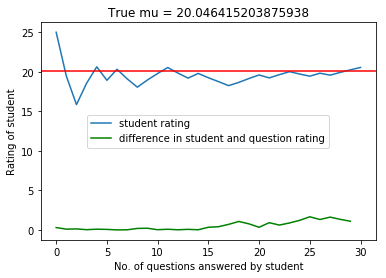

In [161]:
# Method 4
plot_convergence('I078', lower_qns_bank_ABC, 30)

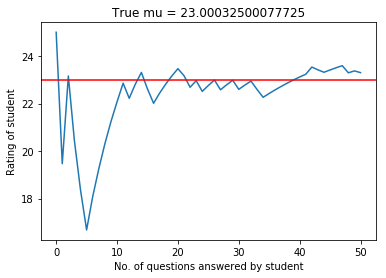

In [35]:
# Method 4
plot_convergence('I322', A_qns, 50)

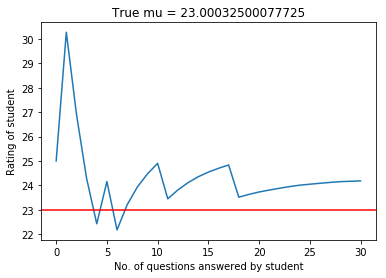

In [22]:
# Method 4
plot_convergence('I322', lower_qns_bank_A, 30)

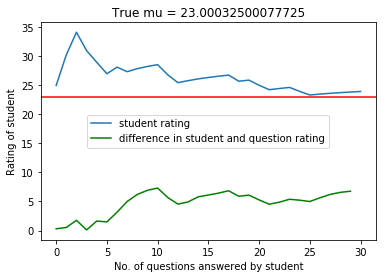

In [164]:
# Method 4
plot_convergence('I322', lower_qns_bank_AB, 30)

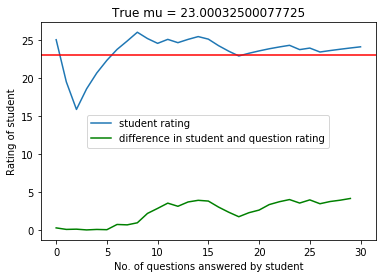

In [165]:
# Method 4
plot_convergence('I322', lower_qns_bank_ABC, 30)

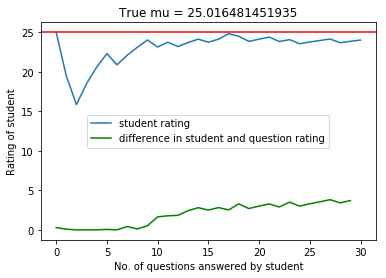

In [171]:
# Method 4
plot_convergence('I294', lower_qns, 30)

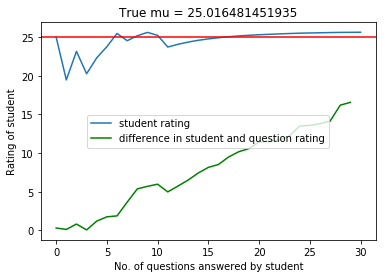

In [167]:
# Method 4
plot_convergence('I294', lower_qns_bank_A, 30)

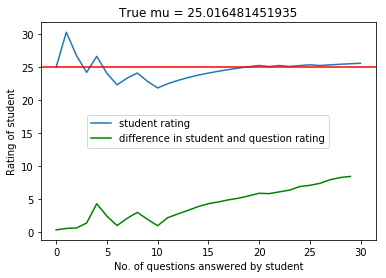

In [168]:
# Method 4
plot_convergence('I294', lower_qns_bank_AB, 30)

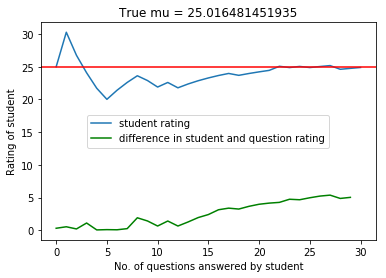

In [169]:
# Method 4
plot_convergence('I294', lower_qns_bank_ABC, 30)

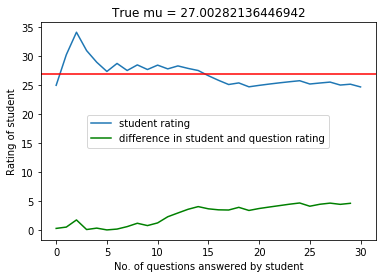

In [176]:
# Method 4
plot_convergence('I028', lower_qns, 30)

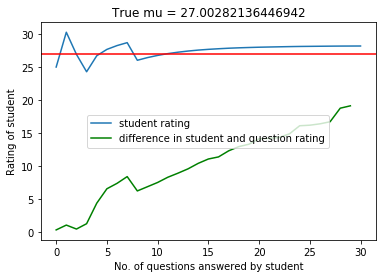

In [178]:
# Method 4
plot_convergence('I028', lower_qns_bank_A, 30)

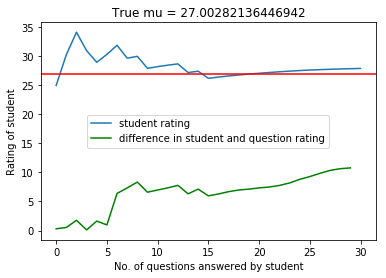

In [179]:
# Method 4
plot_convergence('I028', lower_qns_bank_AB, 30)

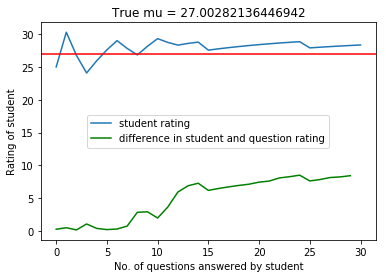

In [107]:
# Method 4
plot_convergence('I028', lower_qns_bank_ABC, 30)

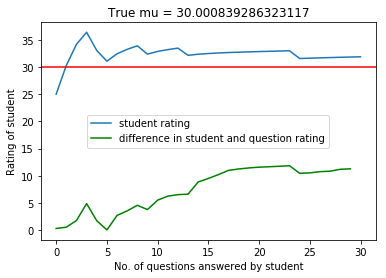

In [108]:
# Method 4
plot_convergence('I259', lower_qns, 30)

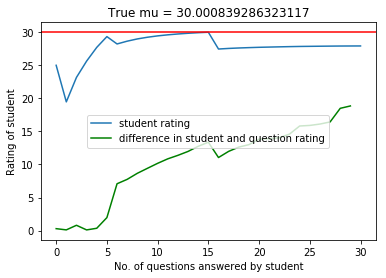

In [109]:
# Method 4
plot_convergence('I259', lower_qns_bank_A, 30)

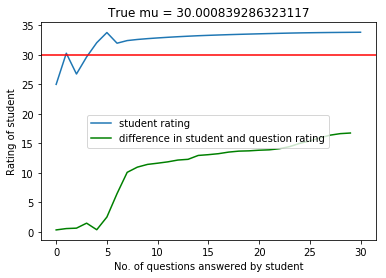

In [110]:
# Method 4
plot_convergence('I259', lower_qns_bank_AB, 30)

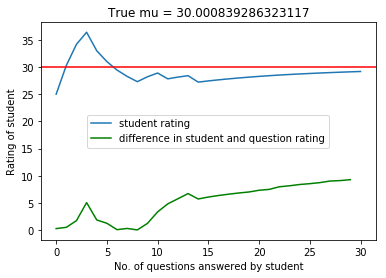

In [111]:
# Method 4
plot_convergence('I259', lower_qns_bank_ABC, 30)

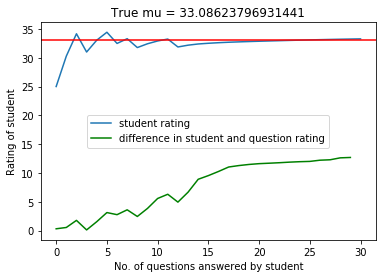

In [112]:
# Method 4
plot_convergence('I245', lower_qns, 30)

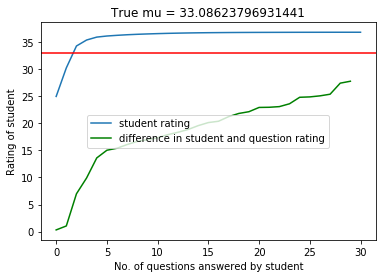

In [113]:
# Method 4
plot_convergence('I245', lower_qns_bank_A, 30)

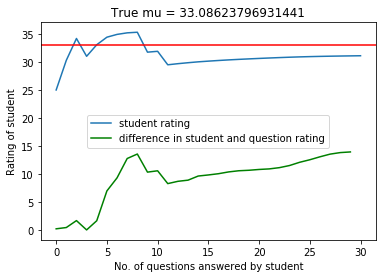

In [114]:
# Method 4
plot_convergence('I245', lower_qns_bank_AB, 30)

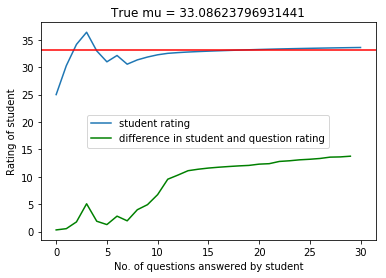

In [115]:
# Method 4
plot_convergence('I245', lower_qns_bank_ABC, 30)

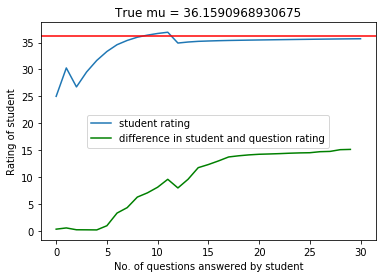

In [116]:
# Method 4
plot_convergence('I314', lower_qns, 30)

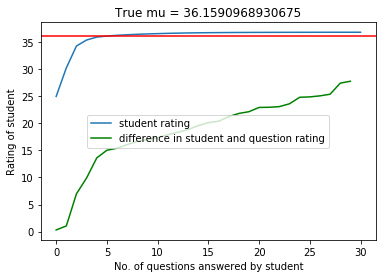

In [117]:
# Method 4
plot_convergence('I314', lower_qns_bank_A, 30)

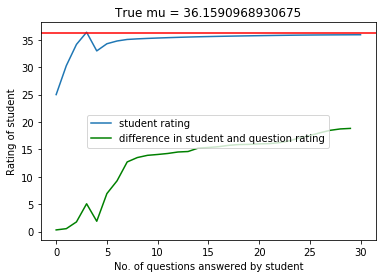

In [118]:
# Method 4
plot_convergence('I314', lower_qns_bank_AB, 30)

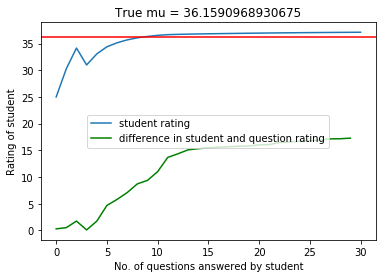

In [119]:
# Method 4
plot_convergence('I314', lower_qns_bank_ABC, 30)

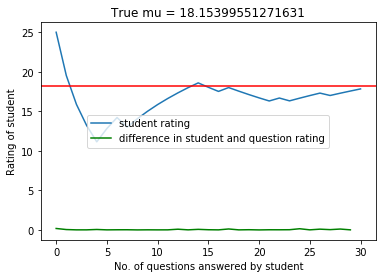

In [120]:
# Method 4
plot_convergence('I632', all_qns, 30)

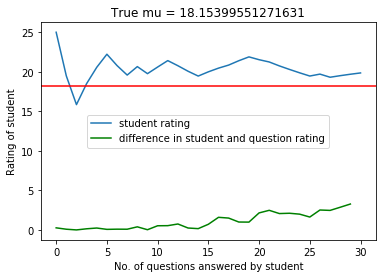

In [121]:
# Method 4
plot_convergence('I632', all_qns_bank_A, 30)

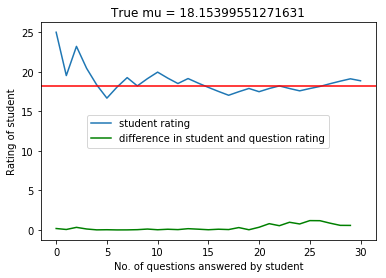

In [122]:
# Method 4
plot_convergence('I632', all_qns_bank_AB, 30)

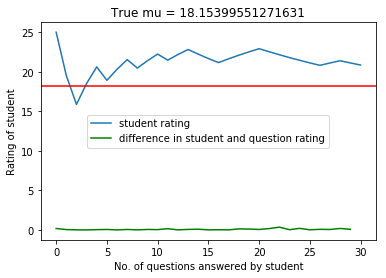

In [123]:
# Method 4
plot_convergence('I632', all_qns_bank_ABC, 30)

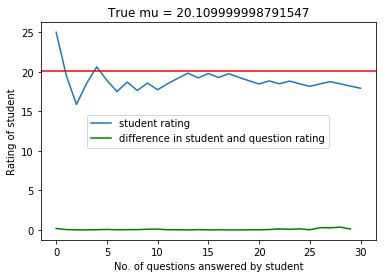

In [124]:
# Method 4
plot_convergence('I432', all_qns, 30)

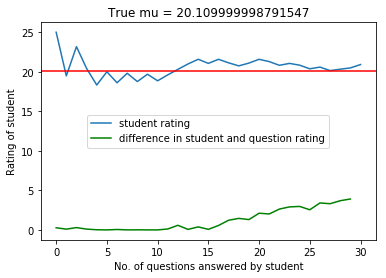

In [125]:
# Method 4
plot_convergence('I432', all_qns_bank_A, 30)

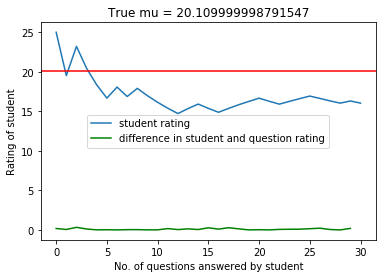

In [126]:
# Method 4
plot_convergence('I432', all_qns_bank_AB, 30)

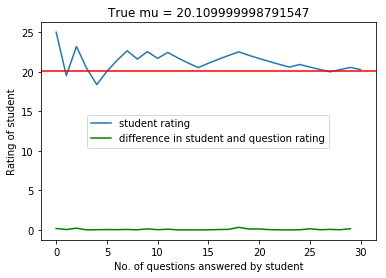

In [127]:
# Method 4
plot_convergence('I432', all_qns_bank_ABC, 30)

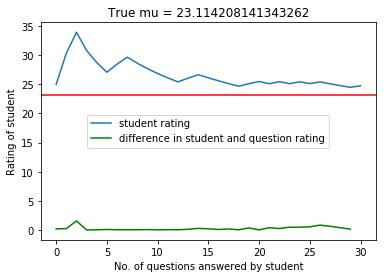

In [128]:
# Method 4
plot_convergence('I701', all_qns, 30)

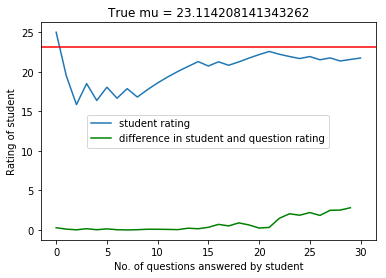

In [129]:
# Method 4
plot_convergence('I701', all_qns_bank_A, 30)

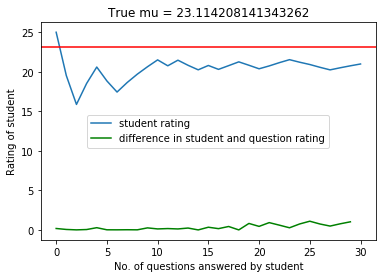

In [130]:
# Method 4
plot_convergence('I701', all_qns_bank_AB, 30)

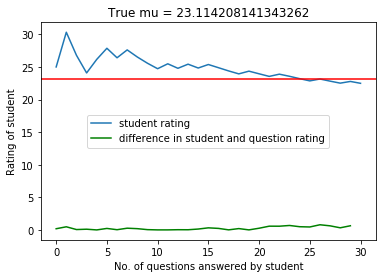

In [131]:
# Method 4
plot_convergence('I701', all_qns_bank_ABC, 30)

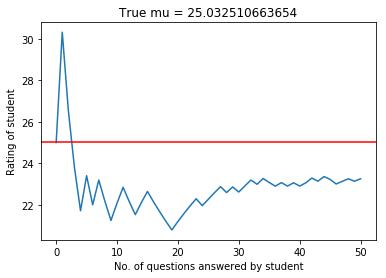

In [52]:
# Method 4
plot_convergence('I428', all_qns, 50)

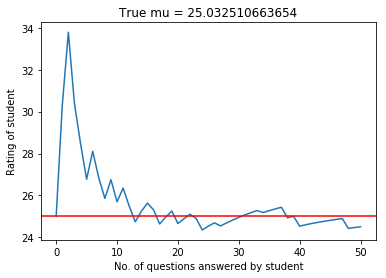

In [60]:
# Method 4
plot_convergence('I428', all_qns_bank_A, 50)

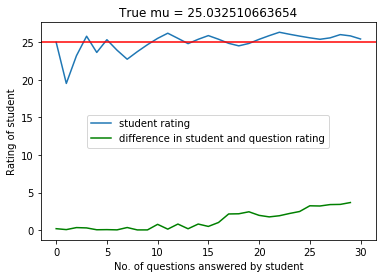

In [134]:
# Method 4
plot_convergence('I428', all_qns_bank_AB, 30)

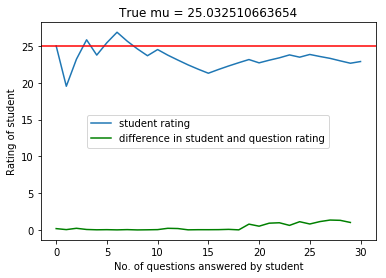

In [135]:
# Method 4
plot_convergence('I428', all_qns_bank_ABC, 30)

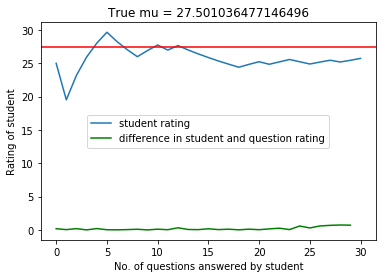

In [136]:
# Method 4
plot_convergence('I519', all_qns, 30)

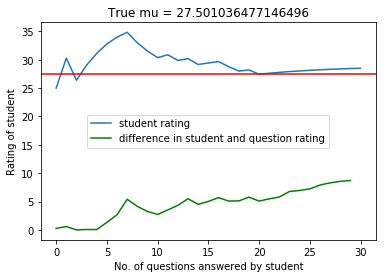

In [137]:
# Method 4
plot_convergence('I519', all_qns_bank_A, 30)

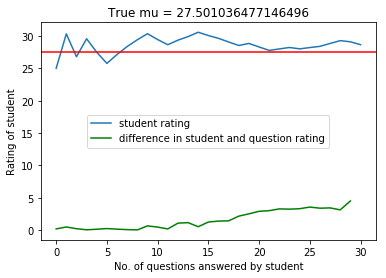

In [138]:
# Method 4
plot_convergence('I519', all_qns_bank_AB, 30)

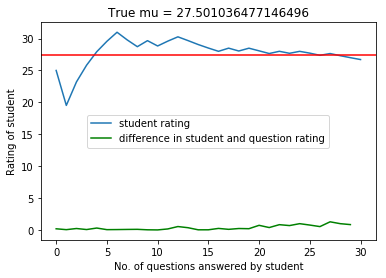

In [139]:
# Method 4
plot_convergence('I519', all_qns_bank_ABC, 30)

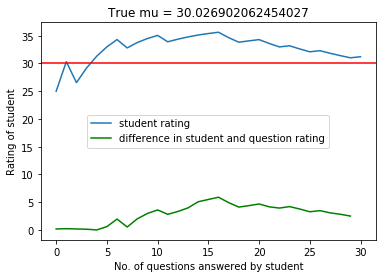

In [140]:
# Method 4
plot_convergence('I689', all_qns, 30)

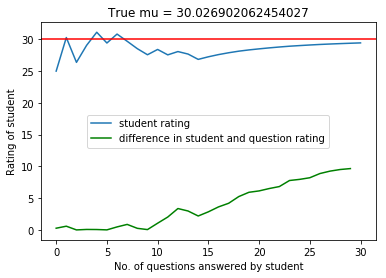

In [141]:
# Method 4
plot_convergence('I689', all_qns_bank_A, 30)

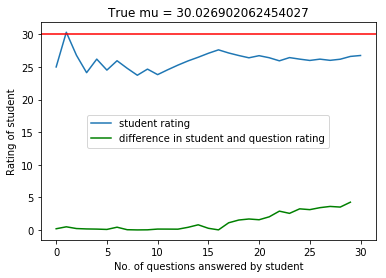

In [142]:
# Method 4
plot_convergence('I689', all_qns_bank_AB, 30)

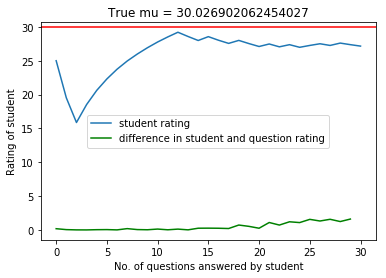

In [143]:
# Method 4
plot_convergence('I689', all_qns_bank_ABC, 30)

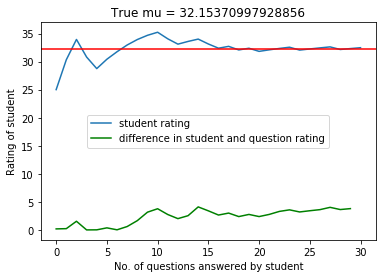

In [144]:
# Method 4
plot_convergence('I570', all_qns, 30)

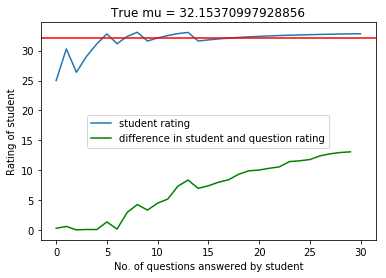

In [145]:
# Method 4
plot_convergence('I570', all_qns_bank_A, 30)

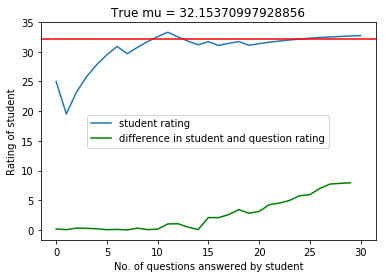

In [146]:
# Method 4
plot_convergence('I570', all_qns_bank_AB, 30)

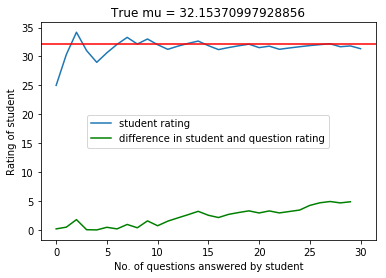

In [147]:
# Method 4
plot_convergence('I570', all_qns_bank_ABC, 30)

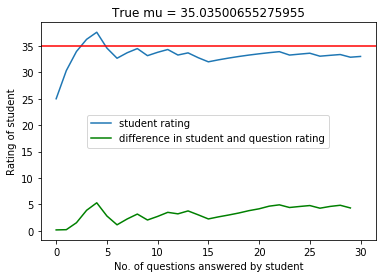

In [148]:
# Method 4
plot_convergence('I728', all_qns, 30)

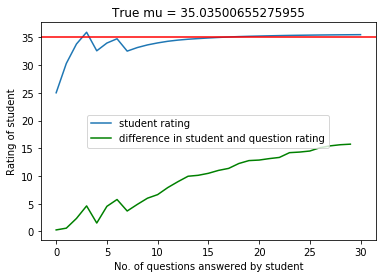

In [149]:
# Method 4
plot_convergence('I728', all_qns_bank_A, 30)

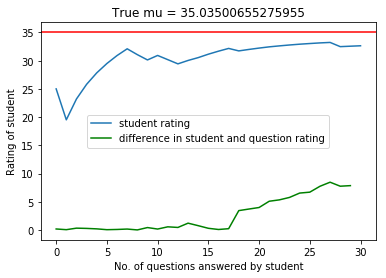

In [150]:
# Method 4
plot_convergence('I728', all_qns_bank_AB, 30)

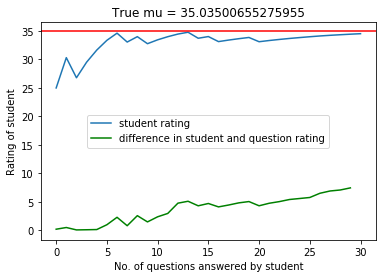

In [151]:
# Method 4
plot_convergence('I728', all_qns_bank_ABC, 30)